<a href="https://colab.research.google.com/github/hishaam19/RockID/blob/TrainingModelsAlex/Rock_recognition_modelAlex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import os
from keras import layers
from keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D,regularization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import regularizers
import seaborn as sns

In [2]:

img_width=80
img_height=80
batch_size=20
num_of_classes=17

TRAIN_DIR= "/content/drive/MyDrive/Datasets/cleaned_dataset/train"
TEST_DIR= "/content/drive/MyDrive/Datasets/cleaned_dataset/test"
VAL_DIR = "/content/drive/MyDrive/Datasets/cleaned_dataset/val"

In [3]:
#preprocessing datasets
train_data = ImageDataGenerator(
                                    #rescale=1./255,
                                    #shear_range=0.2,
                                    #zoom_range=0.2,
                                    horizontal_flip=False,

                                    vertical_flip=False  )

val_data = ImageDataGenerator(horizontal_flip=False)
test_data = ImageDataGenerator(horizontal_flip=False)

train_gen = train_data.flow_from_directory(TRAIN_DIR,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                target_size=(img_height, img_width))





val_gen = val_data.flow_from_directory(VAL_DIR,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                target_size=(img_height, img_width)
                                                            )
test_gen = test_data.flow_from_directory(TEST_DIR,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                target_size=(img_height, img_width)
                                                            )

Found 2212 images belonging to 17 classes.
Found 271 images belonging to 17 classes.
Found 291 images belonging to 17 classes.


In [4]:
model=Sequential()
pretrained_model=tf.keras.applications.EfficientNetB3(include_top=False,
              weights='imagenet',
              input_shape=(img_height,img_width,3),pooling='max')
for layer in pretrained_model.layers:
  layer.trainable = True

#model.add(BatchNormalization(synchronized=True))
#model.add(Dense(512,bias_regularizer='l1_l2',kernel_regularizer='l1_l2',activity_regularizer='l1_l2',activation='relu'))
model.add(pretrained_model)

#model.add(Flatten())
#3model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.5))
model.add(Dense(17, activation='softmax'))


model.compile(optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics =['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense (Dense)               (None, 17)                26129     
                                                                 
Total params: 10,809,664
Trainable params: 10,722,361
Non-trainable params: 87,303
_________________________________________________________________


In [5]:
ModelCallbacks = [EarlyStopping(monitor='val_loss', patience=5,  restore_best_weights=True)]

history = model.fit(train_gen,
                                epochs=5,
                                verbose=1,
                                validation_data=val_gen

                                )

Epoch 1/5
111/111 [==============================] - 474s 4s/step - loss: 2.0647 - accuracy: 0.4458 - val_loss: 1.8256 - val_accuracy: 0.5498
Epoch 2/5
111/111 [==============================] - 12s 112ms/step - loss: 1.0433 - accuracy: 0.6700 - val_loss: 1.2231 - val_accuracy: 0.6642
Epoch 3/5
111/111 [==============================] - 12s 112ms/step - loss: 0.7931 - accuracy: 0.7500 - val_loss: 1.7216 - val_accuracy: 0.5756
Epoch 4/5
111/111 [==============================] - 11s 102ms/step - loss: 0.6542 - accuracy: 0.7916 - val_loss: 1.1165 - val_accuracy: 0.6863
Epoch 5/5
111/111 [==============================] - 13s 115ms/step - loss: 0.5337 - accuracy: 0.8336 - val_loss: 1.5184 - val_accuracy: 0.6162


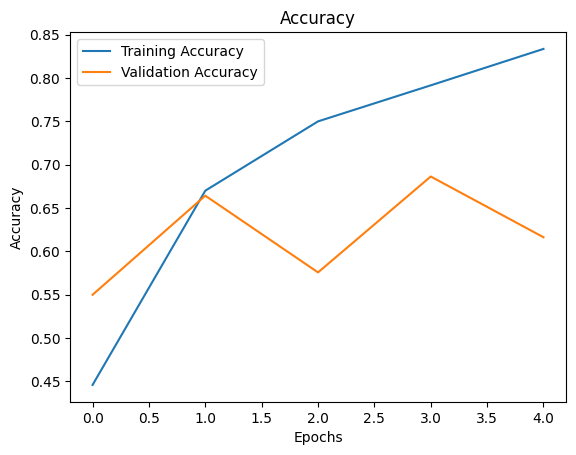

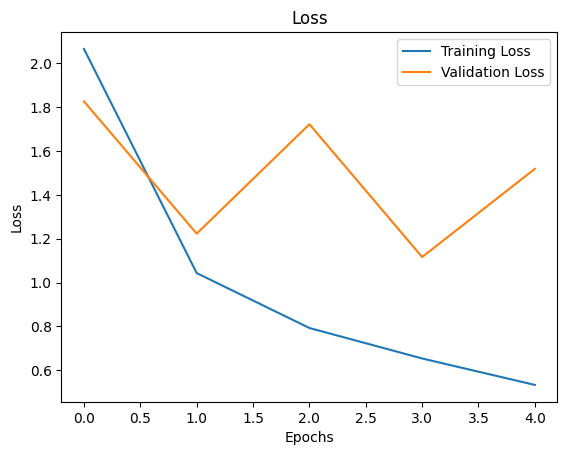

In [6]:


#Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate test data
15/15 [==============================] - 52s 4s/step - loss: 1.4432 - accuracy: 0.6323
Test Loss: 1.4432224035263062
Test Accuracy: 0.6323024034500122


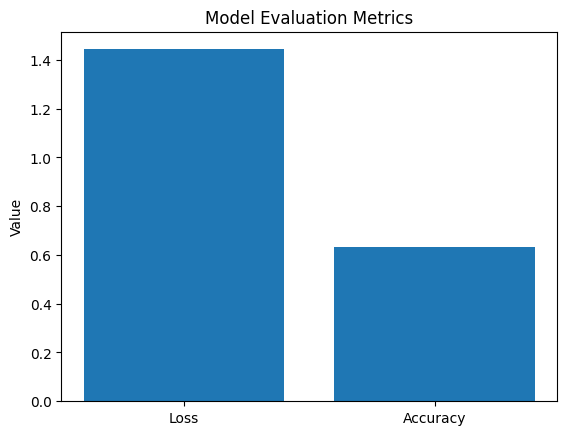

In [7]:
print("Evaluate test data")
#Save model

#model.save('test1.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_gen)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Plot the evaluation metrics
metrics = ['Loss', 'Accuracy']
values = [test_loss, test_accuracy]

plt.bar(metrics, values)
plt.ylabel('Value')
plt.title('Model Evaluation Metrics')
plt.show()

14/14 [==============================] - 6s 63ms/step


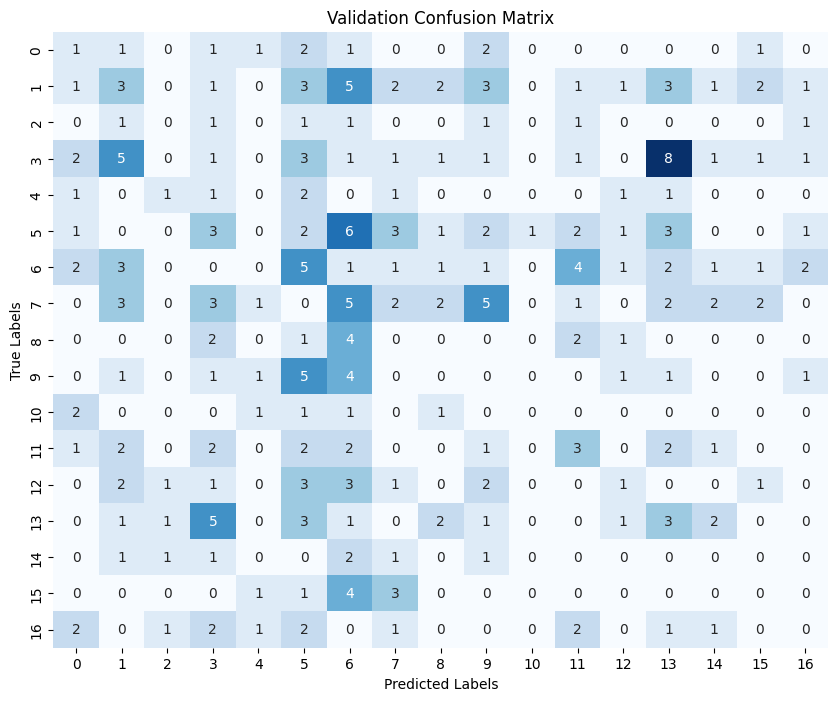

In [8]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
num_classes = val_gen.num_classes
y_train_true = val_gen.classes
y_train_pred_probs = model.predict(val_gen)
y_train_pred_classes = np.argmax(y_train_pred_probs, axis=1)

train_cm = confusion_matrix(y_train_true, y_train_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()